# Imports and Constants

In [1]:
# Libraries for data frame manipulations and visualizations
import polars as pl
import pandas as pd
import networkx as nx
import numpy as np
import pyarrow
from datetime import datetime
import re
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import seaborn as sns
from mpl_chord_diagram import chord_diagram
from query_data import get_endpoint, query_number_of_letters_and_actors, query_all_letters, query_actors

from collections import defaultdict, OrderedDict, Counter
from itertools import product, combinations

In [2]:
pl.Config.set_fmt_table_cell_list_len(30)

FIG_SIZE = (10,10)

# Common metadata fields / column to group by / layers in multilayer network
KEY = "datasource"

# Edge (letter) metadata fields
SOURCE = "source" # source node (node id)
TARGET = "target" # target node (node id)
TIMESTAMP = "date" # time stamp
TIMETYPE = "date_type" # type of the timestamp, if many (YYYY, DD.MM.YYYY, YYYY-YYYY etc.)
EVENT = "evt" # id for the edge


# Node (actor) metadata fields
NODE = "person" # node id
NUM_SOURCES = "len_sources" # number of KEYs
KEYS = "sources"


In [3]:
# Short labels for data sources in KEY
short_sources = {'Åbo Akademi University Library':'Åbo Akademi',
 'The National Library of Finland':'National Library',
 "The National Archives of Finland":'National Archives',
 'Finnish Literature Society':'SKS',
 'The Society of Swedish Literature in Finland':'SLS',
 'J. V. Snellman Letters':'Snellman Letters',
 'Elias Lönnrot Letters':'Lönnrot Letters',
 'Albert Edelfelt Letters':'Edelfelt Letters',
 'Finnish National Gallery':'National Gallery',
 'Finnish National Gallery (Word files)':'National Gallery',
 'Serlachius Museums':'Serlachius Museums',
 'Zacharias Topelius Writings':'Topelius Letters',
 'Gallen-Kallela Museum':'Gallen-Kallela Museum',
 'Migration Institute of Finland':'Migration Institute',
 'The Migration Institute of Finland':'Migration Institute',
 'Migration Institute of Finland (Word files)':'Migration Institute',
 'Postal Museum':'Postal Museum',
 'Aalto University Archives': 'Aalto University',
 'Theatre Museum':'Theatre Museum',
 'The Archives of President Urho Kekkonen':'Kekkonen Archives',
 'Hämeenlinna City Museum':'Hämeenlinna City Museum'
}

# Import Data Frames

There should be two data frames, one that handles the edge data (e.g. letters) and one that handles the node data (e.g. letter writers and receivers). The edge data should include at least edge id (EVT), source and target node ids (SOURCE and TARGET) and the KEY (e.g. data source). Edge data can include any other metadata. Then node data should include at least the node id and the KEY.

In [4]:
# Transform a pandas DataFrame to a Polars DataFrame
#df_polars = pl.from_pandas(df_pandas)

In [5]:
endpoint = get_endpoint()

In [6]:
# Read/query edge data frame
#df_edges = query_all_letters(endpoint, save="../dataframes/edges_6_25.parquet")
df_edges = pl.read_parquet("../dataframes/edges_11_6_25.parquet")
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language
str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""8.6.1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""20.10.1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""24.3.1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""15.6.1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""19.3.1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"


In [7]:
# Combine columns Finnish National Gallery (Word files) and Finnish National Gallery etc.
datasource_to_change = {n:n for n in list(df_edges.select("datasource").unique()["datasource"].to_list())}
datasource_to_change["Finnish National Gallery (Word files)"] = "Finnish National Gallery"
datasource_to_change["Migration Institute of Finland (Word files)"] = "Migration Institute of Finland"
df_edges = df_edges.with_columns(pl.col("datasource").replace_strict(datasource_to_change))

# Replace missing values with None
#df_edges = df_edges.with_columns(pl.all().replace_strict({'http://ldf.fi/schema/coco/missing_value': np.nan, '> Missing value': np.nan}))
df_edges = df_edges.with_columns(
    pl.when(pl.col("language") == 'http://ldf.fi/schema/coco/missing_value')
    .then(None)
    .otherwise(pl.col("language"))
    .alias("language")
)
df_edges = df_edges.with_columns(
    pl.when(pl.col("target_place") == '> Missing value')
    .then(None)
    .otherwise(pl.col("target_place"))
    .alias("target_place")
)

df_edges = df_edges.with_columns(
    pl.when(pl.col("sending_place") == '> Missing value')
    .then(None)
    .otherwise(pl.col("sending_place"))
    .alias("sending_place")
)
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language
str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""8.6.1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null
"""http://ldf.fi/coco/letters/HCM…","""20.10.1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null
"""http://ldf.fi/coco/letters/HCM…","""24.3.1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null
"""http://ldf.fi/coco/letters/HCM…","""15.6.1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null
"""http://ldf.fi/coco/letters/HCM…","""19.3.1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null


In [8]:
# Add short labels for data sources
df_edges = df_edges.with_columns(
    short_sources=pl.col("datasource").replace_strict(short_sources)
)
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language,short_sources
str,str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""8.6.1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null,"""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""20.10.1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null,"""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""24.3.1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null,"""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""15.6.1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null,"""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""19.3.1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null,"""Hämeenlinna City Museum"""


In [9]:
# Assign different datetypes for letters based on string expression of letter sending dates
def check_date(date1, return_type=True):
  

  if date1 == pl.Null: # Letter has no date assigned
    if return_type:
      return "MISSING"
    return date1
  date1 = date1.strip() 
  if re.search(r'\d', date1) is None: # date does not contain any numbers, e.g. s.a.
    if return_type:
      return "OTHER"
    return date1

  if re.search("^\d{4}$", date1): # YYYY
    if return_type:
      return "YYYY"
    return date1
  if re.search("\[\d{4}\]$", date1): # [YYYY]
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()
  if re.search("^\d{4},\s*s.a.", date1): # [YYYY,s.a.
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()
  if re.search("^\d{4},\s*s. a.", date1): # [YYYY,s. a.
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()

  if re.search("^\d{4}\s*\W\s*\d{4}", date1): # YYYY - YYYY
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{4}", date1).group())
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0].strip())}-{int(parts[1].strip())}"
  if re.search("^\d{4}\s*\W\s*\d{2}$", date1): # YYYY - YY
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{2}", date1).group())
    parts[0] = parts[0].strip()
    parts[1] = parts[0][:2] + parts[1].strip()
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0])}-{int(parts[1])}"
  if re.search("^\d{4}\s*\W\s*\d{2},\s*s.a.$", date1): # YYYY - YY, s.a.
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{2}", date1).group())
    parts[0] = parts[0].strip()
    parts[1] = parts[0][:2] + parts[1].strip()
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0])}-{int(parts[1])}"
  
  date1 = date1.replace(" 00:00:00", "")
  if re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1): # YYYY.MM.DD
    try:
      if '-' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y-%m-%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '.' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y.%m.%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '\\' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y\\%m\\%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '/' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y/%m/%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
    except ValueError: # Month and day are probably 0, take only the year
      if return_type:
        return "YYYY"
      return date1[:4]
  if re.search("^\d{1,2}\.\d{1,2}\.\d{4}$", date1): # DD.MM.YYYY
    try:
      date = datetime.strptime(re.search("^\d{1,2}\.\d{1,2}\.\d{4}$", date1).group(0), "%d.%m.%Y")
      if return_type:
        return "YYYY.MM.DD"
      return date.strftime("%d-%m-%Y")
    except ValueError: # Month and day are probably 0, take only the year
      if return_type:
        return "YYYY"
    
  if return_type:
    return "OTHER"
  return date1

In [10]:
# Check dates and add date type column

df_edges = df_edges.with_columns(
    pl.col("date")
    .map_elements(check_date, return_dtype=pl.String)
    .alias("date_type")
)

df_edges = df_edges.with_columns(
    pl.col("date")
    .map_elements(lambda d: check_date(d, return_type=False), return_dtype=pl.String)
    .alias("date")
)


df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language,short_sources,date_type
str,str,str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""08-06-1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""20-10-1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""24-03-1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""15-06-1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""19-03-1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""


In [11]:
# Read/query node data frame
#df_nodes = query_actors(endpoint, save="../dataframes/nodes_6_25.parquet")
df_nodes = pl.read_parquet("../dataframes/nodes_11_6_25.parquet")

In [12]:
# Change occupations/links columns form strings to lists
df_nodes = df_nodes.with_columns(
    pl.col("occupations").str.split(by=";").alias("occupations"),
    pl.col("links").str.split(by=";", inclusive=False).alias("links"),
    pl.col("sources").str.split(by=";", inclusive=False).alias("sources"),
)
df_nodes = df_nodes.with_columns(
    pl.col("occupations").list.len().alias("len_occupations"),
    pl.col("links").list.len().alias("len_links"),
    pl.col("sources").list.len().alias("len_sources")
)

# Change null values to 0 for chosen columns
df_nodes = df_nodes.with_columns(pl.col(["out_degree", "in_degree", "num_correspondences"]).fill_null(strategy="zero"))

"""
# Change gender "> Not applicable" (for family and group type actors) to None
df_nodes = df_nodes.with_columns(
    pl.when(pl.col("gender") == "> Not applicable")
    .then(None)
    .otherwise(pl.col("gender"))
    .alias("gender")
)
"""
df_nodes.head()

person,label,type,birthyear,deathyear,deathplace,occupations,birthplace,out_degree,in_degree,num_correspondences,floruit,gender,sources,links,len_occupations,len_links,len_sources
str,str,str,i64,i64,str,list[str],str,i64,i64,i64,str,str,list[str],list[str],u32,u32,u32
"""http://ldf.fi/coco/provided/p0…","""Neiglick, Alexander Johan""","""Person""",1828,1888,"""Pietari""","[""bank manager"", ""bookkeeper"", ""copyist"", ""non-commissioned officer""]","""Impilahti""",45,1,11,"""http://ldf.fi/coco/times/time_…","""Male""","[""Albert Edelfelt Letters"", ""The National Archives of Finland"", ""Finnish National Gallery"", ""The National Library of Finland"", ""Finnish Literature Society""]","[""http://ldf.fi/yoma/people/p16695"", ""http://www.wikidata.org/entity/Q131427494""]",4,2,5
"""http://ldf.fi/coco/provided/p1…","""Lindström, Anna""","""Person""",1870,1962,"""Turku""",null,"""Turku""",2,0,2,"""http://ldf.fi/coco/times/time_…","""Female""","[""Åbo Akademi University Library"", ""The National Library of Finland""]",null,null,null,2
"""http://ldf.fi/coco/provided/p9…","""Isakson, A.""","""Person""",1886,1929,"""Vaasa""","[""politician"", ""journalist""]",null,5,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The Society of Swedish Literature in Finland""]","[""http://ldf.fi/semparl/people/p910584"", ""http://urn.fi/URN:NBN:fi:au:finaf:000174120"", ""http://www.wikidata.org/entity/Q11853357""]",2,3,1
"""http://ldf.fi/coco/provided/p2…","""Suomalais-Virolaiselle liitto""","""Organization""",null,null,null,null,null,0,1,1,"""http://ldf.fi/coco/times/time_…","""> Not applicable""","[""Finnish Literature Society""]",null,null,null,1
"""http://ldf.fi/coco/provided/p1…","""Brunou, Gustaf Adolf""","""Person""",1779,1833,null,null,null,2,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The National Archives of Finland""]","[""http://ldf.fi/nbf/p93197""]",null,1,1


In [13]:
#  Calculate degree by summing in- and out-degrees
df_nodes = (
    df_nodes
    .lazy()
    .with_columns(
        (pl.col('in_degree') + pl.col('out_degree')).alias('degree')
    )
    .collect()
)

In [14]:
# Check if certain external links are included and put them into separate column
df_nodes = df_nodes.with_columns(
    yoma_link=pl.col("links").list.filter(pl.element().str.contains("http://ldf.fi/yoma")),
    nbf_link=pl.col("links").list.filter(pl.element().str.contains('http://ldf.fi/nbf')),
    wiki_link=pl.col("links").list.filter(pl.element().str.contains('http://www.wikidata.org'))
)
df_nodes = df_nodes.with_columns(
    pl.when(pl.col(["yoma_link","nbf_link","wiki_link"]).list.len() > 0).then(pl.col(["yoma_link","nbf_link","wiki_link"]))
)
# Replace Unknown genders with None
df_nodes = df_nodes.with_columns(
    pl.when((pl.col("gender") != "Unknown")).then(pl.col("gender")).otherwise(None)
)
df_nodes.head()

person,label,type,birthyear,deathyear,deathplace,occupations,birthplace,out_degree,in_degree,num_correspondences,floruit,gender,sources,links,len_occupations,len_links,len_sources,degree,yoma_link,nbf_link,wiki_link
str,str,str,i64,i64,str,list[str],str,i64,i64,i64,str,str,list[str],list[str],u32,u32,u32,i64,list[str],list[str],list[str]
"""http://ldf.fi/coco/provided/p0…","""Neiglick, Alexander Johan""","""Person""",1828,1888,"""Pietari""","[""bank manager"", ""bookkeeper"", ""copyist"", ""non-commissioned officer""]","""Impilahti""",45,1,11,"""http://ldf.fi/coco/times/time_…","""Male""","[""Albert Edelfelt Letters"", ""The National Archives of Finland"", ""Finnish National Gallery"", ""The National Library of Finland"", ""Finnish Literature Society""]","[""http://ldf.fi/yoma/people/p16695"", ""http://www.wikidata.org/entity/Q131427494""]",4,2,5,46,"[""http://ldf.fi/yoma/people/p16695""]",null,"[""http://www.wikidata.org/entity/Q131427494""]"
"""http://ldf.fi/coco/provided/p1…","""Lindström, Anna""","""Person""",1870,1962,"""Turku""",null,"""Turku""",2,0,2,"""http://ldf.fi/coco/times/time_…","""Female""","[""Åbo Akademi University Library"", ""The National Library of Finland""]",null,null,null,2,2,null,null,null
"""http://ldf.fi/coco/provided/p9…","""Isakson, A.""","""Person""",1886,1929,"""Vaasa""","[""politician"", ""journalist""]",null,5,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The Society of Swedish Literature in Finland""]","[""http://ldf.fi/semparl/people/p910584"", ""http://urn.fi/URN:NBN:fi:au:finaf:000174120"", ""http://www.wikidata.org/entity/Q11853357""]",2,3,1,5,null,null,"[""http://www.wikidata.org/entity/Q11853357""]"
"""http://ldf.fi/coco/provided/p2…","""Suomalais-Virolaiselle liitto""","""Organization""",null,null,null,null,null,0,1,1,"""http://ldf.fi/coco/times/time_…","""> Not applicable""","[""Finnish Literature Society""]",null,null,null,1,1,null,null,null
"""http://ldf.fi/coco/provided/p1…","""Brunou, Gustaf Adolf""","""Person""",1779,1833,null,null,null,2,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The National Archives of Finland""]","[""http://ldf.fi/nbf/p93197""]",null,1,1,2,null,"[""http://ldf.fi/nbf/p93197""]",null


In [15]:
df_numbers = df_edges.group_by("datasource").n_unique()[["datasource", "evt"]]
df_numbers = df_numbers.rename({"evt":"Letters"})
df_numbers = df_numbers.with_columns(
    short_sources=pl.col("datasource").replace_strict(short_sources)
)
actor_counts = {"datasource":[], "Actors":[]}
for s in df_numbers["datasource"]:
    actor_counts["datasource"].append(s)
    actor_counts["Actors"].append(df_nodes.filter(pl.col(KEYS).list.contains(s)).shape[0])
df_actor_counts = pl.from_dict(actor_counts)

df_numbers = df_numbers.join(df_actor_counts, on="datasource").sort(by="Letters", descending=True)
df_numbers

datasource,Letters,short_sources,Actors
str,u32,str,i64
"""Åbo Akademi University Library""",366614,"""Åbo Akademi""",27350
"""The National Archives of Finla…",292073,"""National Archives""",32325
"""The National Library of Finlan…",281157,"""National Library""",33632
"""The Society of Swedish Literat…",198490,"""SLS""",16013
"""Finnish Literature Society""",116646,"""SKS""",13882
…,…,…,…
"""Serlachius Museums""",411,"""Serlachius Museums""",136
"""Aalto University Archives""",295,"""Aalto University""",261
"""Gallen-Kallela Museum""",144,"""Gallen-Kallela Museum""",3


# Functions

Functions for visualizing the data.

In [16]:
# Get potential letter duplicates as data frame

def get_letter_duplicates(df_edges, aggregates=[], timetypefilter="YYYY.MM.DD", same_sources=False):
    """
    df_edges (pl.DataFrame):            edges data frame
    aggregates (list of strinds):     other metadata fields for comparison e.g. sending/receiving places
    timetypefilter (str):             what timetype is included
    same_sources (bool):              include potential duplicates within sources
    """
    df_duplicates = df_edges
    df_duplicates = df_duplicates.filter(pl.col(TIMETYPE) == timetypefilter).group_by([TIMESTAMP, SOURCE, TARGET]).agg(pl.col(KEY), pl.col(EVENT).len(), *aggregates)
    df_duplicates = df_duplicates.filter(pl.col(EVENT)>1)
    df_duplicates = df_duplicates.with_columns(pl.col(KEY).list.unique().alias("num_"+KEY))
    df_duplicates = df_duplicates.with_columns(pl.col("num_"+KEY).list.len().alias("num_"+KEY))
    if not same_sources:
        df_duplicates = df_duplicates.filter(pl.col("num_"+KEY)>1)
    return df_duplicates


In [17]:
def table_as_figure(df, index_column, columns=[], save_file=None):
    # Plot chosen columns of dataframe as table
    """
    df (pl.DataFrame):       data frame to plot
    index_column (str):      x tick labels
    columns (list):          columns to be included
    save_file (str):         name of the file to save the figure 
    """
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Set background color white
    norm = plt_colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
        [norm( 1.0), "white"]]
    cmap = plt_colors.LinearSegmentedColormap.from_list("", colors)
    if len(columns) > 0:
        sns.heatmap(df.drop(index_column)[columns], cbar=False, annot=True, ax=ax,cmap=cmap, fmt='d', linewidths=0.5, linecolor='black', annot_kws={"fontsize":12}, clip_on=False)
    else:
        sns.heatmap(df.drop(index_column), cbar=False, annot=True, ax=ax,cmap=cmap, fmt='d', linewidths=0.5, linecolor='black', annot_kws={"fontsize":12}, clip_on=False)

    ax.set_yticklabels(df.get_column(index_column), rotation=0)
    ax.set_xticklabels(columns)

    # Move seaborn heatmap xlabels on top of the picture
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
    
    if save_file is not None:
        fig.savefig(save_file, format="pdf", dpi=600, bbox_inches = 'tight')

In [18]:
def link_metadata(df, columns, save_file=None, title="", key=KEY):
    # Plot heatmap about the availability of link metadata
    """
    df (pl.DataFrame):  edge data frame
    columns (list):     list of columns included in the heat map
    save_file (str):    name of the file to save the figure
    title (str):        title of the figure
    """

    df = df_edges.group_by(key).agg([pl.col(c).count() for c in [EVENT]+columns]).sort(EVENT, descending=True)
    df = df.with_columns(pl.all().exclude(key)/pl.col(EVENT))
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    ax1 = sns.heatmap(df[columns], annot=True, cmap='Greens',annot_kws={"fontsize":12})
    ax1.set_xticklabels(columns)
    ax1.set_yticklabels(df[key], rotation=0)
    #ax1.set_xlabel('Available metadata', fontsize=12)
    #ax1.set_ylabel('Data source', fontsize=12)
    ax1.set(xlabel = '', ylabel = '')
    ax1.set_title(label=title, fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='both', which='minor', labelsize=14)
    plt.show()
    if save_file is not None:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [19]:
def shared_actor_pairs_graph(df_edges, groupby=KEY, weight="actors", save_file=None):
    # Create network of datasources based on shared actors or letters
    # weight: letters = maximum number of potentially shared letters
    #         actors = number of shared sender-recipient pairs
    """
    df_edges (pl.DataFrame):     edge data frame
    groupby (str):               nodes
    weight (str):                if "actors" the weight between nodes is counted as shared actors,
                                 otherwise the weight is the number of potentially shared edges (based on source and target nodes only)
    save_file (str):             name of the file to save the figure, if None figure is not saved
    """
    
    if weight=="actors":
        df_diag = df_edges.group_by(groupby).agg(pl.struct(SOURCE, TARGET).n_unique().alias("total"))
    else:
        df_diag = df_edges.group_by(groupby).agg(pl.col(EVENT).n_unique().alias("total"))

    df_key_edges = df_edges.group_by([SOURCE, TARGET, groupby]).agg(pl.col(EVENT).len())
    df_key_edges = df_key_edges.group_by([SOURCE, TARGET]).agg(pl.col(groupby), pl.col(EVENT))
    
    G = nx.Graph()
    
    for row in df_key_edges.iter_rows(named=True):
        for (n1,n2),(w1,w2) in zip(combinations(row[groupby],2),combinations(row[EVENT],2)):
            if G.has_edge(n1,n2):
                if weight=="actors":
                    G[n1][n2]['weight'] += 1 
                else:
                    G[n1][n2]['weight'] += min(row[EVENT])
            else:
                if weight=="actors":
                    G.add_edge(n1,n2,weight=1)
                else:
                    G.add_edge(n1,n2,weight=min(row[EVENT]))
    for n in df_diag[groupby]:
        G.add_edge(n,n, weight=df_diag.filter(pl.col(groupby)==n).select(pl.col("total")).item(0,0))
    return G

def plot_heatmap(G, weight="weight", nodelist=None, save_file=None, title="", vmax=1300):
    if not nodelist:
        nodelist = list(G.nodes())
    adj_matrix = nx.adjacency_matrix(G, weight=weight, nodelist=nodelist).toarray()
    adj_df = pd.DataFrame(adj_matrix, index=[n for n in nodelist], columns=[n for n in nodelist])
    mask = np.triu(np.ones_like(adj_df.corr(), dtype=bool),k=1) #Plot only the lower triangle
    annotations = adj_matrix

    plt.figure(figsize=FIG_SIZE)
    sns.heatmap(adj_df, annot=annotations, cmap="viridis", fmt=".0f",mask=mask, cbar=False,vmin=0,vmax=vmax)
    plt.grid(False)
    plt.title(title)
    plt.xticks(rotation=70)

    if save_file is not None:
        plt.savefig(save_file, format='png', dpi=1500, bbox_inches = 'tight')

In [20]:
def create_multigraph_from_edges(all_edges, edge_types=KEY):
    # Create multigraph based on edges
    """
    all_edges (pl.DataFrame):    edge data frame
    edge_types (str):            column name that defines the edge keys/types
    """

    edges = all_edges.group_by([SOURCE, TARGET, edge_types]).agg(pl.col(EVENT).count()).rename({EVENT:"weight"})
    G = nx.from_pandas_edgelist(
        edges,
        source=SOURCE,
        target=TARGET,
        edge_key=edge_types,
        edge_attr=["weight"],
        create_using=nx.MultiDiGraph(),
    )
    return G

In [21]:
def get_nodes_with_multiple_keys(G):
    # Nodes that are associated with multiple 
    node_keys = {n:[] for n in G.nodes}
    for n1,n2,k in G.edges(keys=True):
        if k not in node_keys[n1]:
            node_keys[n1].append(k)
        if k not in node_keys[n2]:
            node_keys[n2].append(k)
    multisource_nodes = [n for n in node_keys if len(node_keys[n])>1]
    multinode_prop = len(multisource_nodes)/G.number_of_nodes()
    return multisource_nodes, multinode_prop

In [22]:
def degree_dist(G, nodeset=[], logplot=True):
    # Degree distribution of graph
    """
    G (NetworkX graph):  graph for plotting
    nodeset (list):      list of nodes included, if empty list then all nodes
    loglot (bool):       use log scale axes  
    """
    if len(nodeset) == 0:
        nodeset = list(G.nodes())
    deg_multi = Counter()
    for n in nodeset:
        d = G.degree(n)
        deg_multi[d] += 1

    x = []
    y = []
    for key in deg_multi:
        x.append(key)
        y.append(deg_multi[key])

    plt.scatter(x,y)
    if logplot:
        plt.yscale("log")
        plt.xscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")

In [23]:
def actors_source_props_out(df_edges, nodelist, count_all=False):
    # Get the growth of out-degree between biggest KEY and all KEYs
    """
    df_edges (pl.DataFrame):   edge data frame
    nodelist (list):           list of nodes included
    count_all (bool):          if False count only growth between primary and all sources (KEYs),
                               if True count growth by adding one data source (KEY) at time
    """

    df_actors_out = df_edges.filter(pl.col(SOURCE).is_in(nodelist)).group_by([SOURCE, KEY]).agg(pl.col(TARGET))
    df_actors_out = df_actors_out.with_columns(num_targets=pl.col(TARGET).list.n_unique())

    actor_out_counts = [] 
    for a in nodelist:
        df_sources = df_actors_out.filter(pl.col(SOURCE) == a).sort("num_targets", descending=True)
        if df_sources.shape[0]>0:
            actors = []
            actors_s1 = df_sources.row(0)[-1] 
            if count_all:
                for i, row in enumerate(df_sources.iter_rows()):
                    actors += row[2]
                    actors = list(set(actors))
                    actor_out_counts.append([a, i+1, len(actors)/actors_s1, len(actors)])
            else:
                i = df_sources.shape[0]
                for row in df_sources.iter_rows():
                    actors += row[2]
                total_actors = len(set(actors))
                actor_out_counts.append([a,i,total_actors/actors_s1, total_actors])


    df_actor_out_counts = pl.from_numpy(np.array(actor_out_counts), schema=["actor","source_rank","prop", "num_correspondences"])
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("prop").cast(pl.Float32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("num_correspondences").cast(pl.Int32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("source_rank").cast(pl.Int32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.lit("sender").alias("type")).unique(subset=["actor", "source_rank"])
    return df_actor_out_counts

def actors_source_props_in(df_edges, nodelist, count_all=False):
    # Get the growth of in-degree between biggest KEY and all KEYs
    """
    df_edges (data frame):   edge data frame
    nodelist (list):         list of nodes included
    count_all (bool):        if False count only growth between primary and all sources (KEYs),
                             if True count growth by adding one data source (KEY) at time
    """
    df_actors_in = df_edges.filter(pl.col(TARGET).is_in(nodelist)).group_by([TARGET, KEY]).agg(pl.col(SOURCE))
    df_actors_in = df_actors_in.with_columns(num_sources=pl.col(SOURCE).list.n_unique())

    actor_in_counts = [] 

    for a in nodelist:
        df_sources = df_actors_in.filter(pl.col(TARGET) == a).sort("num_sources", descending=True)
        if df_sources.shape[0]>0:
            actors = []
            actors_s1 = df_sources.row(0)[-1] 
            if count_all:
                for i, row in enumerate(df_sources.iter_rows()):
                    actors += row[2]
                    actors = list(set(actors))
                    actor_in_counts.append([a, i+1, len(actors)/actors_s1], len(actors))
            else:
                i = df_sources.shape[0]
                for row in df_sources.iter_rows():
                    actors += row[2]
                total_actors = len(set(actors))
                actor_in_counts.append([a,i,total_actors/actors_s1, total_actors])


    df_actor_in_counts = pl.from_numpy(np.array(actor_in_counts), schema=["actor","source_rank","prop", "num_correspondences"])
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("prop").cast(pl.Float32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("num_correspondences").cast(pl.Int32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("source_rank").cast(pl.Int32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.lit("receiver").alias("type")).unique(subset=["actor", "source_rank"])
    return df_actor_in_counts


def plot_num_actors_in_source(df_edges, nodelist):
    # Plot number of actors that have certain number of sources (KEYs) related to out-going and in-coming links
    """
    df_edges (pl.DataFrame):    edge data frame
    nodelist (list):            nodes included  
    """
    palette = {"sender":"wheat", "receiver":"lightsteelblue"}
    palette2 = {"sender":"orange", "receiver":"royalblue"}


    df_actor_out_counts = actors_source_props_out(df_edges, nodelist)
    df_actor_in_counts = actors_source_props_in(df_edges, nodelist)

    df_actor_counts = pl.concat([df_actor_out_counts, df_actor_in_counts], how="vertical").sort(["source_rank", "type"])
    df_actor_source_counts = df_actor_counts.group_by(["source_rank", "type"]).agg(pl.col("actor").count().alias("actors")).sort(["source_rank", "type"])
    fig, ax = plt.subplots()
    sns.lineplot(data=df_actor_source_counts, x="source_rank", y="actors", hue="type", marker="o",ax=ax, palette=palette2)
    ax.set_xlabel("Number of Sources")
    ax.set_ylabel("Number of Actors")
    plt.gca().yaxis.grid(True)
    

def plot_network_growth(df_edges, nodelist, save_file=None):
    # Plot network growth from primary source to all sources
    """
    df_edges (pl.DataFrame):    edge data frame
    nodelist (list):            nodes included  
    """

    palette = {"sender":"wheat", "receiver":"lightsteelblue"}
    palette2 = {"sender":"orange", "receiver":"royalblue"}

    df_actor_out_counts = actors_source_props_out(df_edges, nodelist)
    df_actor_in_counts = actors_source_props_in(df_edges, nodelist)
    df_actor_counts = pl.concat([df_actor_out_counts, df_actor_in_counts], how="vertical").sort(["source_rank", "type"])
    df_actor_counts2 = df_actor_counts.filter(pl.col("source_rank") != 1)

    fig, ax = plt.subplots(figsize=FIG_SIZE)
    sns.stripplot(
        data=df_actor_counts2, x="source_rank", y="prop", hue="type",
        dodge=True, alpha=.5, legend=False, ax=ax, palette=palette, zorder=1
    )
    sns.pointplot(
        data=df_actor_counts2, x="source_rank", y="prop", hue="type",
        dodge=.4, linestyle="none", errorbar=("pi", 50), legend=True, estimator="median",
        marker="_", markersize=20, markeredgewidth=3, ax=ax, palette=palette2, zorder=5
    )
    plt.gca().yaxis.grid(True)
    ax.set_xlabel("Number of Sources", fontsize=12)
    ax.set_ylabel("Size of the Neighborhood Compared to Primary Source", fontsize=12)

    if save_file is not None:
        plt.savefig(save_file, format='png', dpi=1500, bbox_inches = 'tight')



In [24]:
def nodes_unique_to_key(df_nodes, key):
    unique_nodes = df_nodes.filter(pl.col(KEYS) == [key]).shape[0]
    all_nodes = df_nodes.filter(pl.col(KEYS).list.contains(key)).shape[0]
    return unique_nodes, all_nodes

def unique_nodes_to_keys(df_nodes, keys):
    res = []
    for i,k in enumerate(keys):
        u,a = nodes_unique_to_key(df_nodes,k)
        res.append([k,u,a])
    return pl.from_numpy(np.array(res), schema=["datasource", "unique_nodes", "number_of_nodes"])


In [25]:
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language,short_sources,date_type
str,str,str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""08-06-1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""20-10-1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""24-03-1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""15-06-1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""19-03-1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null,"""Hämeenlinna City Museum""","""YYYY.MM.DD"""


In [26]:
def date_accuracy(df_letters, order=None, hue_order=None, title="", key=KEY, save_file=None):
    # Stacked histogram of date accuracies in LetterSampo Finland
    """
    df_edges (pl.DataFrame):    edge data frame
    order (list):               order of data sources (KEYs) in the y axis
    hue_order (list):           order of date types horizontally
    title (str):                title of the figure
    """
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    if not hue_order:
        color_num = 10
    else:
        color_num = len(hue_order)
    
    df_letters2 = df_letters.select([key, TIMETYPE])

    df_letters2 = df_letters2.to_pandas()
    df_letters2[KEY] = pd.Categorical(df_letters2[key], order)
    ax1 = sns.histplot(
        data=df_letters2,
        y=KEY, hue=TIMETYPE, hue_order=hue_order,
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8, palette=sns.color_palette("gist_earth",color_num)
    )
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
    ax1.set_xlabel('Proportion', fontsize=11)
    ax1.set_ylabel('')
    ax1.set_title(title)
    ax1.get_legend().set_title(title='Date type')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.grid(False)

    if save_file:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [27]:
def plot_degrees_per_source(df_people, title="", save_file=None):
    # Plot number of nodes with certain number of KEYs, and the mean in- and out degree for each number of KEYs
    """
    df_people (pl.DataFrame):  node data frame
    title (str):               title of the figure
    """
    df_degrees = df_people.group_by("len_sources").agg([pl.mean("in_degree"), pl.mean("out_degree"), pl.mean("degree")])
    df_counts = df_people.select(pl.col("len_sources").value_counts(name="num_people")).unnest("len_sources")
    df_degrees = df_degrees.join(df_counts, on="len_sources").sort("len_sources")
    colors = mpl.colormaps['tab20b'].colors

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    #plt.plot(df_degrees['num_sources'], df_degrees['degree'], label='Mean Degree', marker='o', color=colors[2])
    ax.plot(df_degrees['len_sources'], df_degrees['in_degree'], label='Mean In-degree', marker='v', color=colors[6])
    ax.plot(df_degrees['len_sources'], df_degrees['out_degree'], label='Mean Out-degree', marker='^', color=colors[10])
    ax.plot(df_degrees['len_sources'], df_degrees['num_people'], label='Number of Actors', marker='s', color=colors[14])

    ax.set_xlabel('Number of Sources')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    if save_file:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [28]:

def plot_node_metadata(df_nodes, columns=[], columns_labels=[], degrees=[], save_file=None, title="", filters={}):
    # Plot availability of node metadata as heatmap
    """
    df_nodes (pl.DataFrame):     node data frame
    columns (list):              columns (metadata fields) included
    column_labels (list):        alternative column labels for plotting
    degrees (list):              list of minimum degrees for actors to be included (rows of the heat map)
    save_file (str):             name of the file to save the figure, if None figure is not saved
    title (str):                 title of the figure
    filterd (dict):              additional filters for nodes {column_name:required value}
    """
    if len(columns) == 0:
        columns = df_nodes.columns
        columns_labels = columns
    if len(columns_labels) == 0:
        columns_labels = columns

    df_people = df_nodes.to_pandas()
    N_people = df_people.shape[0]
    df_props = df_people.count().to_frame(name=str(N_people)+" /"+"{:>4d}".format(0)) / N_people

    
    for degree in degrees:
        #filtered_df = df_people.loc[(df_people['degree'] >= degree) & (df_people['type'] == 'Person')]
        filtered_df = df_people.loc[(df_people['degree'] >= degree) & (df_people[list(filters)] == pd.Series(filters)).all(axis=1)]
        n_people = filtered_df.shape[0]
        df_props = pd.concat([df_props,filtered_df.count().to_frame(name=str(n_people)+" /"+"{:>4d}".format(degree)) / n_people], axis=1)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df_props.T[columns],annot=True, cmap='Blues',ax=ax)
    plt.xticks(rotation=60)
    if len(columns_labels)==0:
        columns_labels=columns
    ax.set_xticklabels(columns_labels)
    ax.set(xlabel = '', ylabel = "Number of Actors / Minimum Number of Letters", title=title)
    if save_file:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [29]:

def construct_weighted_network(df):
    # Construct weighted network of KEYs, where the edge weight is the number of edges with KEY
    """
    df (pl.DataFrame):   edge data frame
    save_file (str):             name of the file to save the figure, if None figure is not saved
    """
    graph = nx.Graph()
    source_counts = Counter()
    unique_counts = Counter()
   
    for row in df.iter_rows(named=True):
      if row['sources'] is not None:
        sources = row['sources']
        if len(sources) == 1:
          unique_counts[sources[0]] += 1
        for s in sources:
          source_counts[s] += 1
        for source1, source2 in combinations(sources, 2):
          if source1 != source2:
            if graph.has_edge(source1, source2):
              graph[source1][source2]['weight'] += 1
            else:
              graph.add_edge(source1, source2, weight=1)
    
    for n,d in graph.nodes(data=True):
      d['count'] = source_counts[n]
      d['unique'] = unique_counts[n]
    for n in unique_counts:
      if n not in graph:
        graph.add_node(n, count=unique_counts[n], unique=unique_counts[n])
    for n1,n2,d in graph.edges(data=True):
      d['norm_weight1'] = d['weight'] / (source_counts[n1] + source_counts[n2] - d['weight']) # shared actors / all distinct actors in two sources
      d['norm_weight2'] = (source_counts[n1] + source_counts[n2] - 2*d['weight']) / (source_counts[n1] + source_counts[n2] - d['weight']) # not shared actors / all distinct actors
    return graph




def plot_chord_diagram(df_people, save_file=None):
    # Plot chord diagram of nodes related to each KEY
    """
    df_people (pl.DataFrame):  node data frame
    save_file (str):           name of the file to save the figure, if None figure is not saved
    """
   
    weighted_network = construct_weighted_network(df_people)
    weight_props = np.zeros((weighted_network.number_of_nodes(),weighted_network.number_of_nodes()))
    ordered_sources = sorted(weighted_network.nodes(), key=lambda x: weighted_network.nodes[x]['count'], reverse=True)

    for i,(n1,d) in enumerate(weighted_network.nodes(data=True)):
        for j,(n2,d) in enumerate(weighted_network.nodes(data=True)):
            if weighted_network.has_edge(n1,n2):
                weight_props[i,j] = weighted_network[n1][n2]['weight'] / weighted_network.nodes[n1]['count']

    columns = []
    for n,d in weighted_network.nodes(data=True):
        weighted_network.add_edge(n,n, weight=d['unique'])
        columns.append(n)

    A = nx.adjacency_matrix(weighted_network, weight='weight').toarray()
    df_actors = pd.DataFrame(weight_props, columns=[short_sources[n] for n in columns], index=[short_sources[n] for n in columns])
    
    names = list(df_actors.columns)
    order = []
    for s in [short_sources[s2] for s2 in ordered_sources]:
      order.append(names.index(s))

    fig, ax = plt.subplots(figsize=(9,9))
    pos = chord_diagram(A, names=names, order=order, sort="size", directed=False,
                    colors=None, cmap="hsv", use_gradient=True, chord_colors=None,
                    alpha=0.7, start_at=0, extent=360, width=0.1, pad=2., gap=0.03,
                    chordwidth=0.7, min_chord_width=0, fontsize=9,
                    fontcolor="k", rotate_names=True, ax=ax, show=False)
    if save_file:
      fig.savefig(save_file, format='png', bbox_inches = 'tight')

# Visualizations

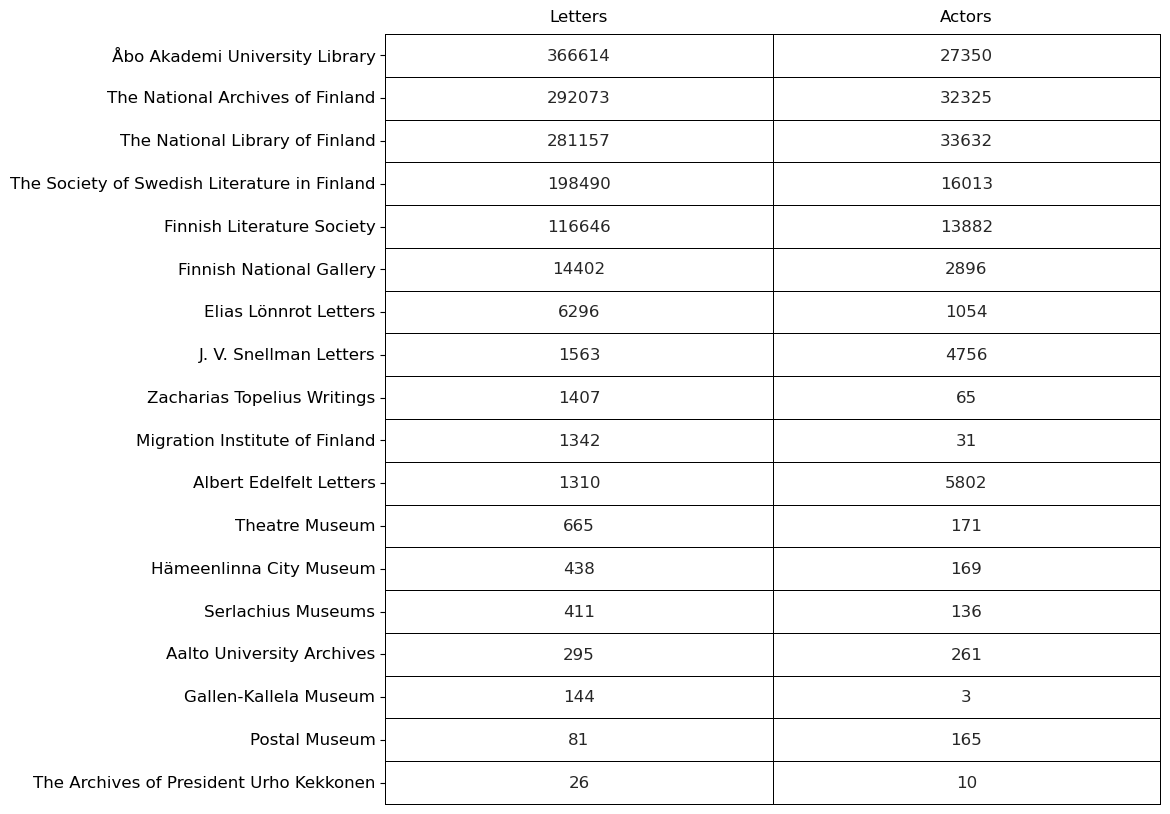

In [30]:
table_as_figure(df_numbers, "datasource", columns=["Letters", "Actors"])

In [31]:
df_unique = unique_nodes_to_keys(df_nodes, list(df_numbers["datasource"]))
df_unique = df_unique.with_columns(prop=pl.col("unique_nodes")/pl.col("number_of_nodes"))
df_unique

datasource,unique_nodes,number_of_nodes,prop
str,str,str,f64
"""Åbo Akademi University Library""","""20285""","""27350""",0.741682
"""The National Archives of Finla…","""24701""","""32325""",0.764145
"""The National Library of Finlan…","""26169""","""33632""",0.778098
"""The Society of Swedish Literat…","""12210""","""16013""",0.762505
"""Finnish Literature Society""","""10040""","""13882""",0.723239
…,…,…,…
"""Serlachius Museums""","""90""","""136""",0.661765
"""Aalto University Archives""","""172""","""261""",0.659004
"""Gallen-Kallela Museum""","""0""","""3""",0.0


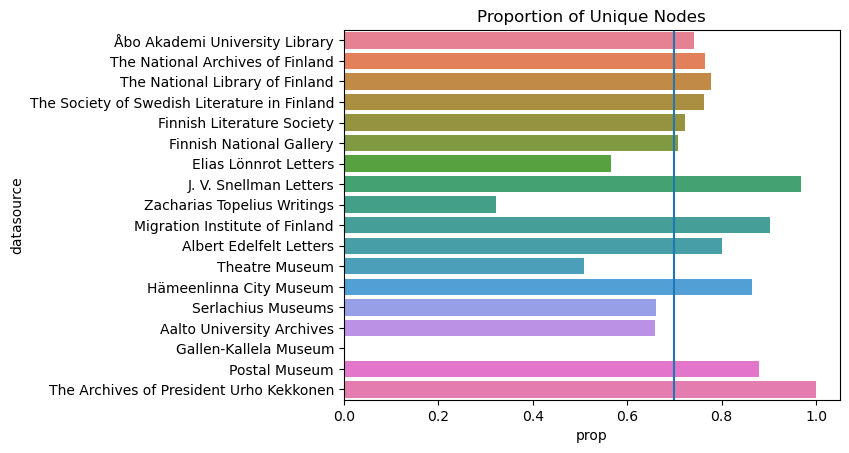

In [32]:
sns.barplot(df_unique, x="prop", y="datasource", hue="datasource", legend=False)
plt.title("Proportion of Unique Nodes")
plt.axvline(0.7)

In [33]:
# Get letter pairs that have the same sender, receiver and sending date
df_dup1 = get_letter_duplicates(df_edges, aggregates=["sending_place", "target_place"])
df_dup1

date,source,target,datasource,evt,sending_place,target_place,num_datasource
str,str,str,list[str],u32,list[str],list[str],u32
"""14-02-1847""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kuopio"", ""Kuopio""]","[null, null]",2
"""03-03-1849""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kuopio"", ""Kuopio""]","[null, null]",2
"""26-12-1846""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kuopio"", ""Kuopio""]","[null, null]",2
"""02-02-1891""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Albert Edelfelt Letters"", ""Finnish National Gallery""]",2,"[""Ospedaletti"", ""Ospedaletti""]","[null, null]",2
"""25-05-1848""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
…,…,…,…,…,…,…,…
"""04-01-1847""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",3,"[""Laukon kartano"", ""Laukon kartano"", ""Vesilahti""]","[null, null, null]",2
"""26-09-1845""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
"""01-11-1844""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Tartto"", ""Tartto""]","[null, null]",2


In [34]:
dupl_counts = Counter()
for l in df_dup1[KEY]:
    for c in combinations(list(l),2):
        dupl_counts[c] += 1

print("Number of potential duplicates between sources:", dupl_counts)
print("Total number of potential duplicates:",sum([v for v in dupl_counts.values()]))

Number of potential duplicates between sources: Counter({('Elias Lönnrot Letters', 'J. V. Snellman Letters'): 30, ('Elias Lönnrot Letters', 'Elias Lönnrot Letters'): 4, ('Albert Edelfelt Letters', 'Finnish National Gallery'): 1})
Total number of potential duplicates: 35


In [35]:
# Get potential duplicate letter pairs that share sender, receiver and sending year
df_dup2 = get_letter_duplicates(df_edges, timetypefilter="YYYY")
df_dup2

date,source,target,datasource,evt,num_datasource
str,str,str,list[str],u32,u32
"""1893""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p0…","[""The National Archives of Finland"", ""Finnish Literature Society"", ""Finnish Literature Society""]",3,2
"""1855""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p1…","[""The National Library of Finland"", ""The Society of Swedish Literature in Finland""]",2,2
"""1904""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","[""Finnish Literature Society"", ""The National Library of Finland"", ""The National Library of Finland""]",3,2
"""1900""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p1…","[""Finnish Literature Society"", ""Finnish Literature Society"", ""The National Library of Finland""]",3,2
"""1898""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p0…","[""Finnish Literature Society"", ""The National Library of Finland"", ""The National Library of Finland""]",3,2
…,…,…,…,…,…
"""1899""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p0…","[""Åbo Akademi University Library"", ""The Society of Swedish Literature in Finland""]",2,2
"""1884""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""Finnish Literature Society"", ""The National Library of Finland"", ""The National Library of Finland"", ""The National Library of Finland"", ""The National Library of Finland""]",12,2
"""1901""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p1…","[""The National Archives of Finland"", ""Åbo Akademi University Library""]",2,2


In [36]:
dupl_counts = Counter()
for l in df_dup2[KEY]:
    for c in combinations(list(l),2):
        dupl_counts[c] += 1

print("Potential duplicates between data sources:",dupl_counts)
print("Total number of potential duplicates:",sum([v for v in dupl_counts.values()]))

Potential duplicates between data sources: Counter({('The Society of Swedish Literature in Finland', 'The Society of Swedish Literature in Finland'): 1774, ('The National Archives of Finland', 'The National Archives of Finland'): 368, ('The National Library of Finland', 'The National Library of Finland'): 100, ('The National Archives of Finland', 'The National Library of Finland'): 92, ('Finnish Literature Society', 'The National Library of Finland'): 65, ('The National Library of Finland', 'The Society of Swedish Literature in Finland'): 63, ('Finnish Literature Society', 'Finnish Literature Society'): 47, ('The National Archives of Finland', 'Finnish Literature Society'): 39, ('The National Archives of Finland', 'Åbo Akademi University Library'): 28, ('The National Archives of Finland', 'The Society of Swedish Literature in Finland'): 24, ('Åbo Akademi University Library', 'The Society of Swedish Literature in Finland'): 23, ('Åbo Akademi University Library', 'The National Library of

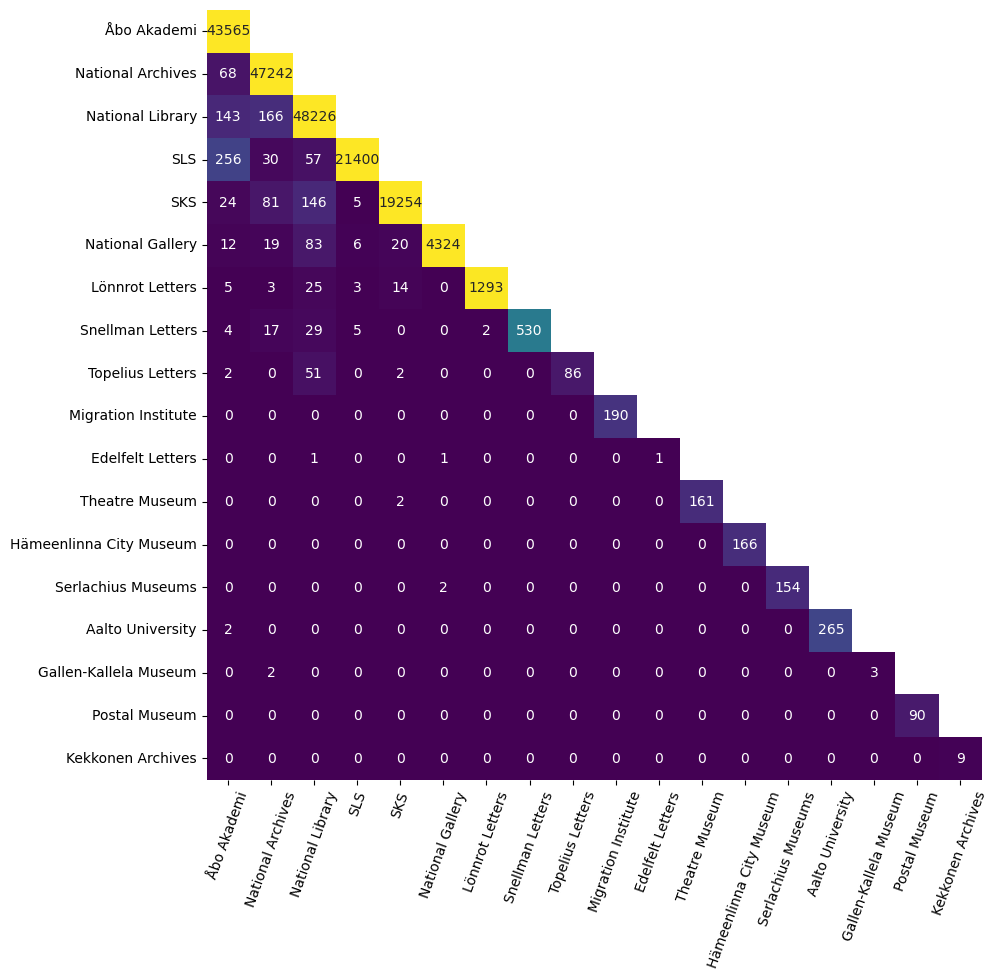

In [37]:
# Shared sender-receiver pairs among datasources
G_shared = shared_actor_pairs_graph(df_edges, groupby="short_sources", weight="actors")
nodelist = []
for n in list(df_numbers['datasource']):
    if short_sources[n] not in nodelist:
        nodelist.append(short_sources[n])
plot_heatmap(G_shared, nodelist=nodelist)

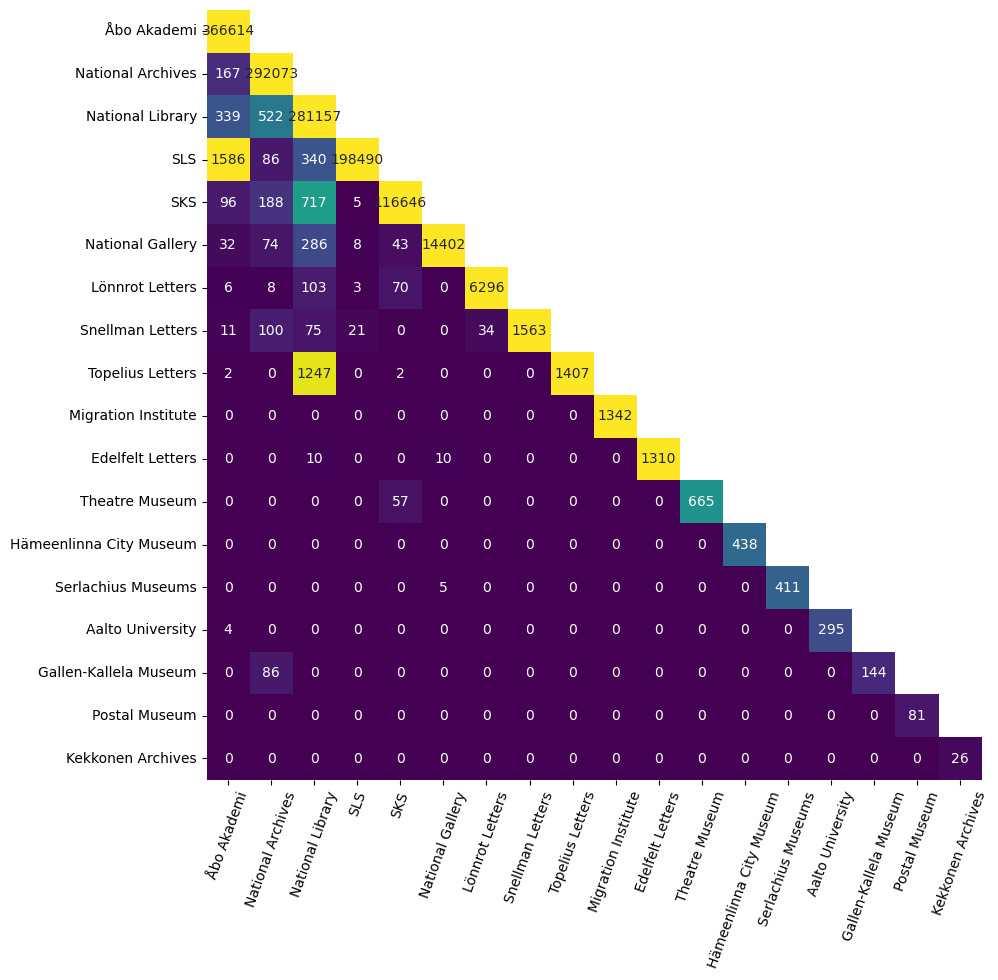

In [38]:
# Potentially shared letters among datasources
G_shared = shared_actor_pairs_graph(df_edges, groupby="short_sources", weight="letters")
plot_heatmap(G_shared, nodelist=nodelist)

In [39]:
total = 0
for n1,n2,d in G_shared.edges(data=True):
    if n1 != n2:
        total += d['weight']
print(total)

6343


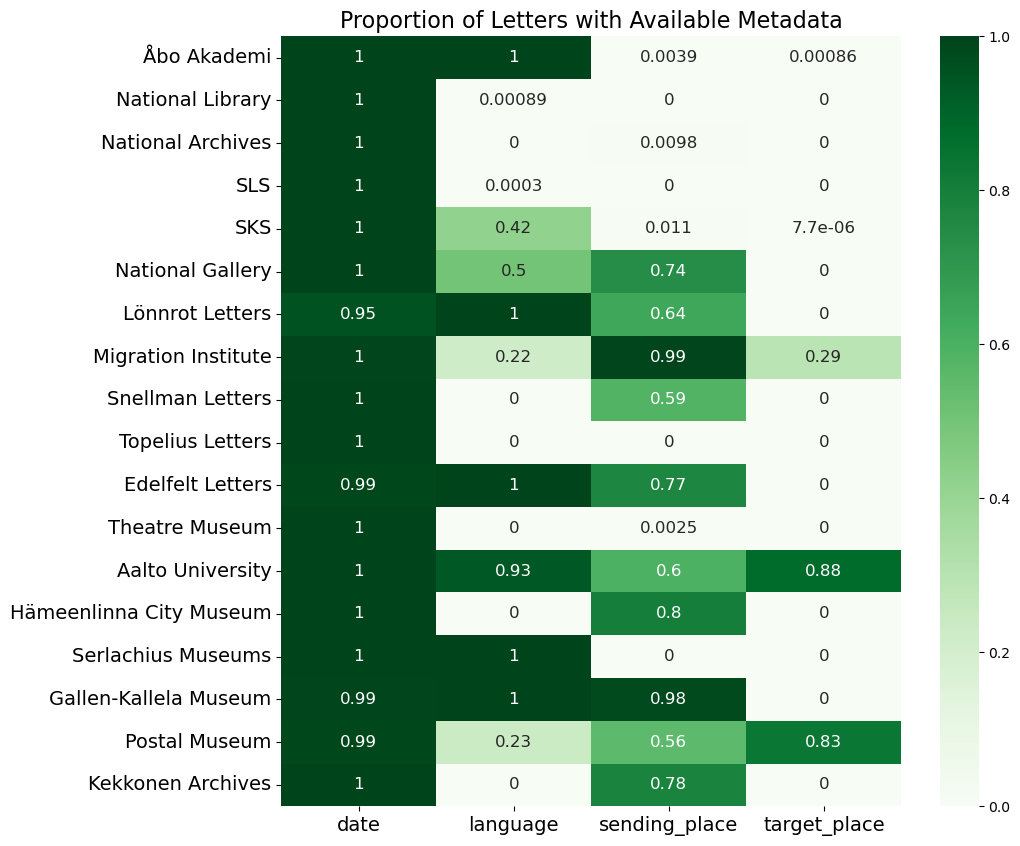

In [40]:
columns = ["date", "language", "sending_place", "target_place"]
link_metadata(df_edges, columns, title='Proportion of Letters with Available Metadata', save_file="../figures/letter_metadata.png", key="short_sources")

In [41]:
df_numbers

datasource,Letters,short_sources,Actors
str,u32,str,i64
"""Åbo Akademi University Library""",366614,"""Åbo Akademi""",27350
"""The National Archives of Finla…",292073,"""National Archives""",32325
"""The National Library of Finlan…",281157,"""National Library""",33632
"""The Society of Swedish Literat…",198490,"""SLS""",16013
"""Finnish Literature Society""",116646,"""SKS""",13882
…,…,…,…
"""Serlachius Museums""",411,"""Serlachius Museums""",136
"""Aalto University Archives""",295,"""Aalto University""",261
"""Gallen-Kallela Museum""",144,"""Gallen-Kallela Museum""",3


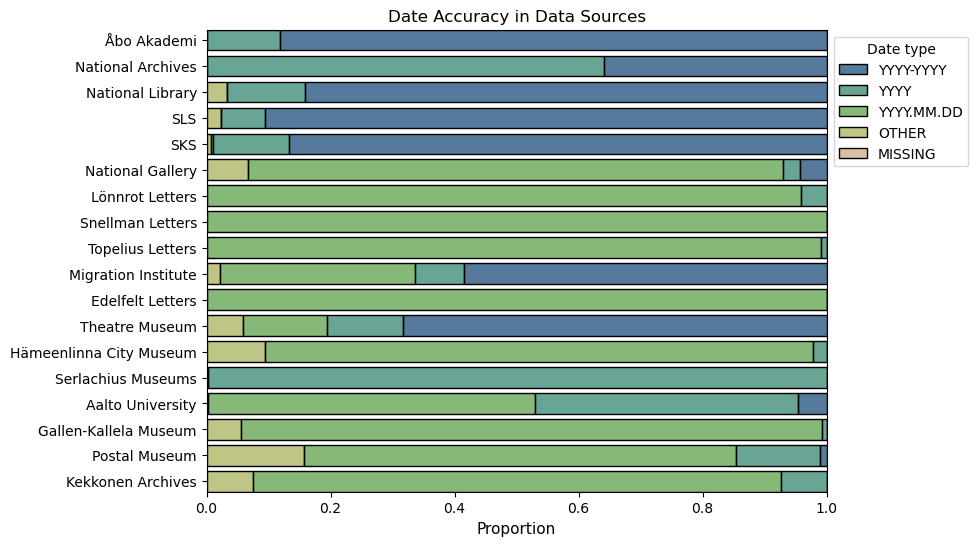

In [42]:
date_accuracy(df_edges,order=list(df_numbers['short_sources']), hue_order=['YYYY-YYYY', 'YYYY', 'YYYY.MM.DD', 'OTHER', 'MISSING'], title="Date Accuracy in Data Sources", key="short_sources", save_file="../figures/letter_dates.png")

In [43]:
G_multi = create_multigraph_from_edges(df_edges)

In [44]:
multisource_nodes, multinode_prop = get_nodes_with_multiple_keys(G_multi) # Get actors present in multiple datasources

print(f"Number of nodes in multiple sources: {len(multisource_nodes)} ({multinode_prop*100:.2f}% out of all the nodes)")

senders_only = [n for n in multisource_nodes if G_multi.in_degree(n, weight="weight") == 0]
receivers_only = [n for n in multisource_nodes if G_multi.out_degree(n, weight="weight") == 0]

print("Belongs to multiple sources but has only sent letters:", len(senders_only), f"({len(senders_only)/len(multisource_nodes)*100:.2f}% of multi source nodes)")
print("Belongs to multiple sources but has only received letters:", len(receivers_only), f"({len(receivers_only)/len(multisource_nodes)*100:.2f}% of multi source nodes)")

Number of nodes in multiple sources: 11312 (10.37% out of all the nodes)
Belongs to multiple sources but has only sent letters: 6719 (59.40% of multi source nodes)
Belongs to multiple sources but has only received letters: 38 (0.34% of multi source nodes)


In [45]:
high_deg_nodes = [n for n,d in sorted(G_multi.degree(weight="weight"), key=lambda x: x[1], reverse=True) if d > 9]
print(f"Number of nodes in with degree at least 10: {len(high_deg_nodes)} ({len(high_deg_nodes)/G_multi.number_of_nodes()*100:.2f}% out of all the nodes)")

Number of nodes in with degree at least 10: 17545 (16.09% out of all the nodes)


In [46]:
low_deg_multinodes = [n for n in multisource_nodes if G_multi.degree(n, weight="weight") < 10]
print("Proportion of nodes belonging to multiple sources but low degree: {:.2f}".format(len(low_deg_multinodes)/len(multisource_nodes)))

Proportion of nodes belonging to multiple sources but low degree: 0.40


In [47]:
# Number of high degree nodes in one or more data sources
high_deg_one = []
high_deg_multi = []
for i, n in enumerate(multisource_nodes):
    if n in high_deg_nodes:
        high_deg_multi.append(n)
    else:
        high_deg_one.append(n)
print(len(high_deg_multi))
print(len(high_deg_one))

6759
4553


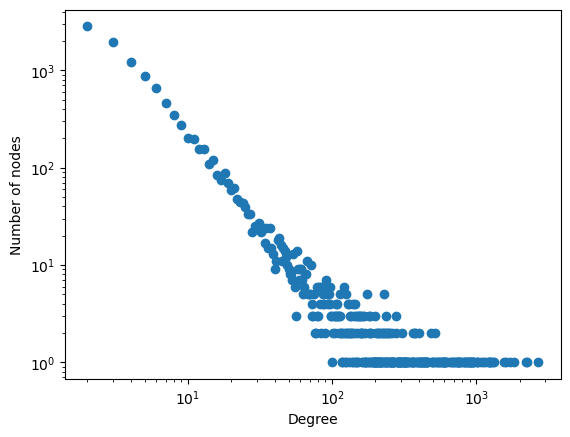

In [48]:
degree_dist(G_multi, multisource_nodes) # Degree distribution of actors with multiple datasources

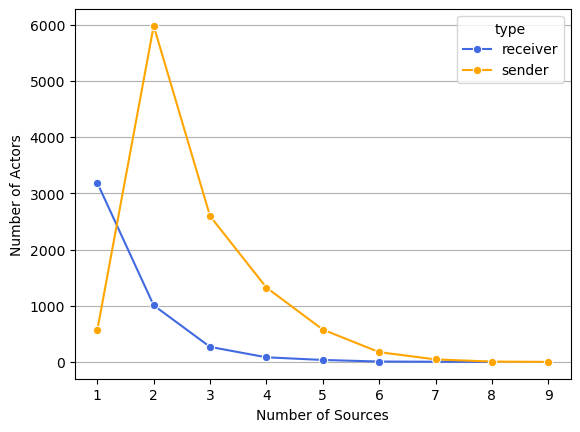

In [49]:
plot_num_actors_in_source(df_edges, nodelist=multisource_nodes)

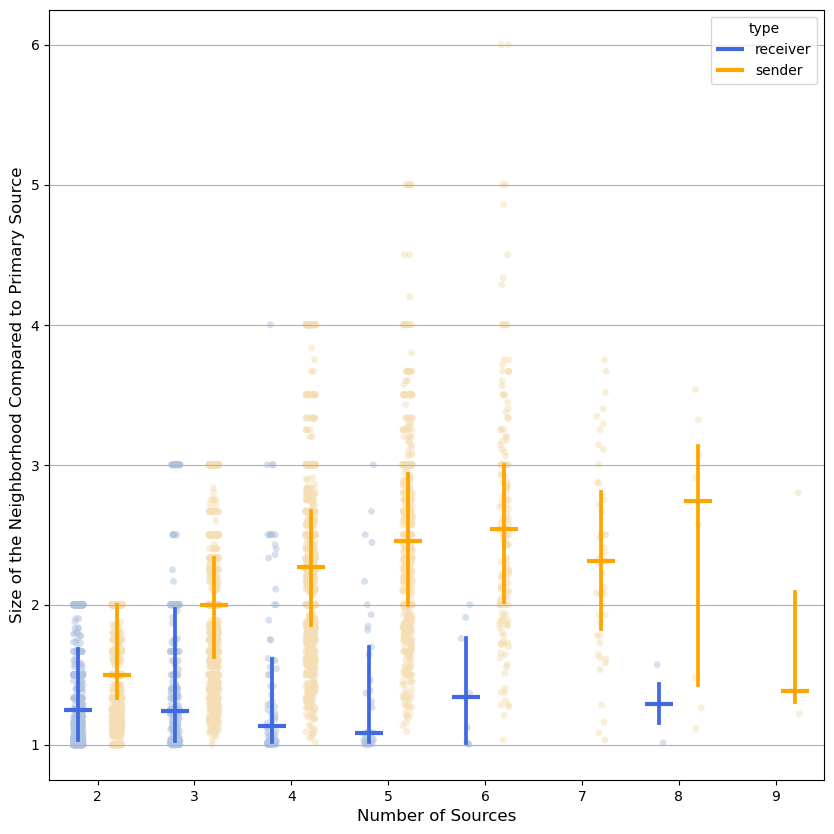

In [50]:
plot_network_growth(df_edges, nodelist=high_deg_multi, save_file="../figures/neighbors_all_vs_primary_source.png")

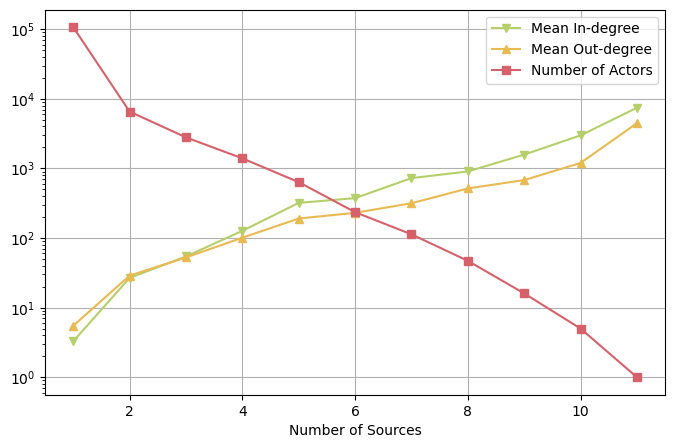

In [51]:
plot_degrees_per_source(df_nodes, save_file="../figures/mean_degrees_per_source.png")

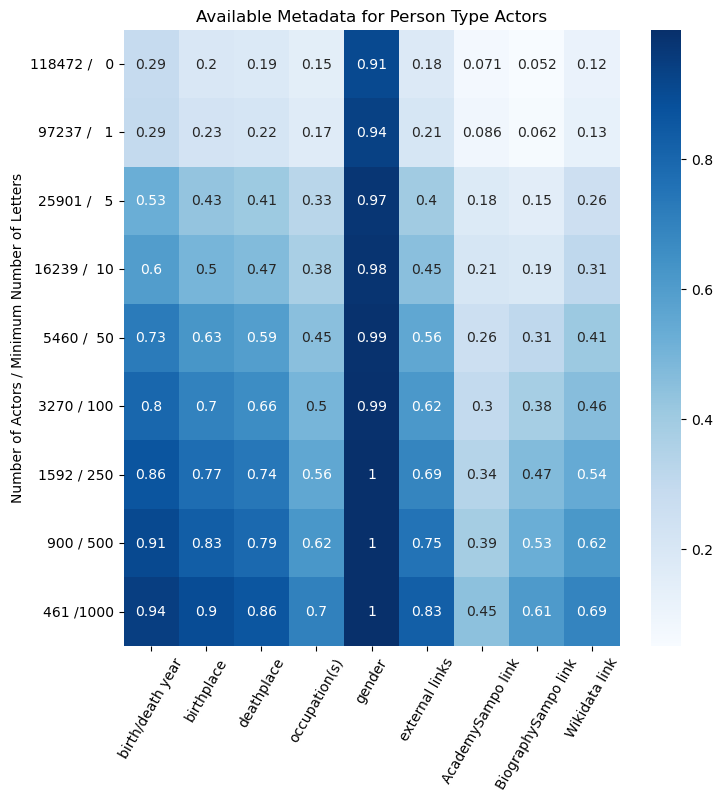

In [52]:
plot_node_metadata(df_nodes, columns=['birthyear', 'birthplace', 'deathplace','occupations','gender','links','yoma_link','nbf_link','wiki_link'],
                    columns_labels=['birth/death year', 'birthplace', 'deathplace','occupation(s)','gender','external links','AcademySampo link','BiographySampo link','Wikidata link'],
                    degrees=[1,5,10,50,100,250,500,1000],
                    title="Available Metadata for Person Type Actors", filters={"type":"Person"}, save_file="../figures/actor_metadata.png")

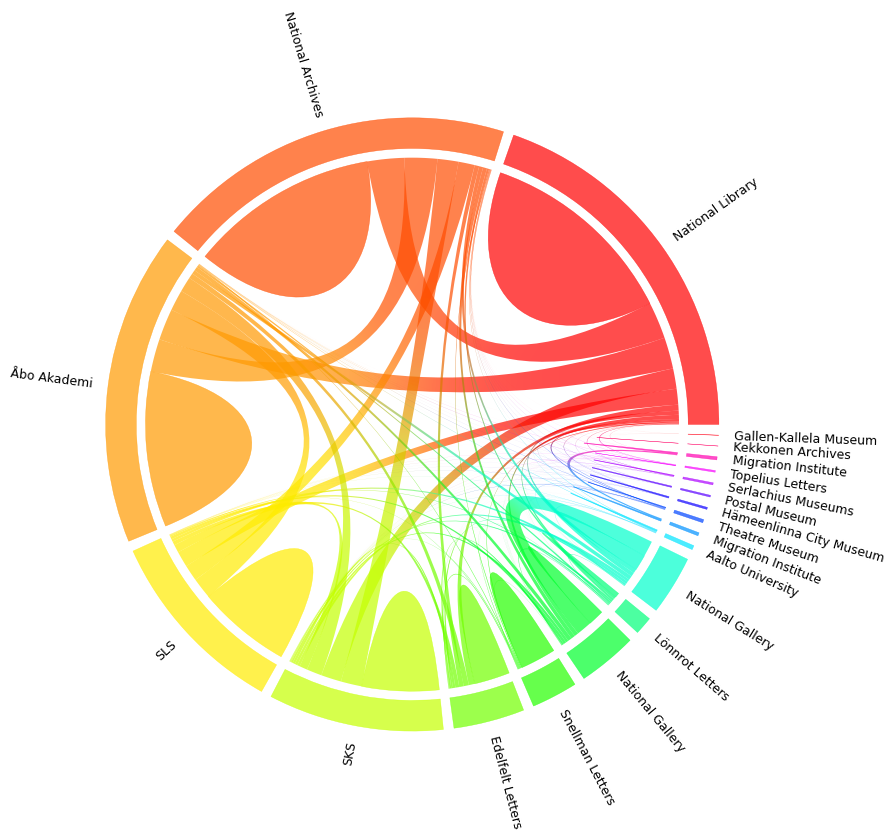

In [53]:
plot_chord_diagram(df_nodes, save_file="../figures/shared_actors.png")